In [ ]:
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [25]:
# Set dataset directories
base_dir = './chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [26]:
# Veri artırma ve ön işleme
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Piksel değerlerini 0-1 aralığına ölçeklendir.
    # Neden: Modelin daha hızlı ve verimli öğrenmesini sağlar.
    
    rotation_range=20,  # Görüntüleri rastgele 0 ile 20 derece arasında döndür.
    # Neden: Modelin farklı açılardan gelen verileri tanıyabilmesini sağlar.
    
    width_shift_range=0.2,  # Görüntüleri yatayda %20 oranında kaydır.
    # Neden: Objelerin görüntüde farklı yatay pozisyonlarda olmasına karşı dayanıklılık sağlar.
    
    height_shift_range=0.2,  # Görüntüleri dikeyde %20 oranında kaydır.
    # Neden: Objelerin görüntüde farklı dikey pozisyonlarda olmasına karşı dayanıklılık sağlar.
    
    shear_range=0.2,  # Görüntüleri %20 oranında kaydırarak bozar.
    # Neden: Objelerin bozulmuş görüntülerini tanıyabilmesini sağlar.
    
    zoom_range=0.2,  # Görüntüleri %20 oranında yakınlaştır veya uzaklaştır.
    # Neden: Objelerin farklı ölçeklerdeki görüntülerini tanıyabilmesini sağlar.
    
    horizontal_flip=True,  # Görüntüleri yatayda çevir (ayna görüntüsü oluşturur).
    # Neden: Objelerin yatay olarak çevrilmiş hallerini tanıyabilmesini sağlar.
    
    fill_mode='nearest'  # Boşlukları en yakın piksel değeri ile doldur.
    # Neden: Dönüşüm ve kaydırma işlemleri sırasında oluşan boşlukları doldurarak görüntülerin tutarlılığını korur.
)


In [27]:
val_test_datagen = ImageDataGenerator(rescale=1./255) # Neden: Piksel değerlerini 0-1 aralığına ölçeklendirir.

In [28]:
# Eğitim veri jeneratörü
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Eğitim verilerinin bulunduğu dizin
    target_size=(150, 150),  # Görüntülerin yeniden boyutlandırılacağı hedef boyut
    batch_size=32,  # Her seferinde işlenecek görüntü sayısı
    class_mode='binary'  # İkili sınıflandırma
)

# Doğrulama veri jeneratörü
val_generator = val_test_datagen.flow_from_directory(
    val_dir,  # Doğrulama verilerinin bulunduğu dizin
    target_size=(150, 150),  # Görüntülerin yeniden boyutlandırılacağı hedef boyut
    batch_size=32,  # Her seferinde işlenecek görüntü sayısı
    class_mode='binary'  # İkili sınıflandırma
)
# Neden: Doğrulama verilerini sadece ölçeklendirme ile model doğrulaması için hazırlar.

# Test veri jeneratörü
test_generator = val_test_datagen.flow_from_directory(
    test_dir,  # Test verilerinin bulunduğu dizin
    target_size=(150, 150),  # Görüntülerin yeniden boyutlandırılacağı hedef boyut
    batch_size=32,  # Her seferinde işlenecek görüntü sayısı
    class_mode='binary'  # İkili sınıflandırma
)
# Neden: Test verilerini sadece ölçeklendirme ile model testleri için hazırlar.

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [29]:
# Eğitim seti için steps_per_epoch ve validation seti için validation_steps hesaplamaları
steps_per_epoch = train_generator.samples // train_generator.batch_size #Bir epoch sırasında modelin kaç batch üzerinde eğitim yapacağını belirtir.
validation_steps = val_generator.samples // val_generator.batch_size  #Bir epoch sırasında modelin kaç batch üzerinde doğrulama yapacağını belirtir.

print(steps_per_epoch)
print(validation_steps)

163
0


In [30]:
from tensorflow.keras.layers import Input

# Modeli oluştur
model = Sequential([
    Input(shape=(150, 150, 3)),  # Giriş katmanı, 150x150 boyutunda ve 3 renk kanallı (RGB) görüntüleri kabul eder
    Conv2D(32, (3, 3), activation='relu'),  # Görüntülerdeki kenarlar, köşeler, dokular gibi düşük seviyeli özellikleri öğrenir.
    MaxPooling2D((2, 2)),  # Görüntü boyutlarını küçültürken en önemli özellikleri korur. Bu, hesaplama maliyetini azaltır ve modelin aşırı uyum (overfitting) yapmasını önler.
    Conv2D(64, (3, 3), activation='relu'),  
    MaxPooling2D((2, 2)), 
    Conv2D(128, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    Flatten(),  # Katmanı düzleştirir, 2B'den 1B'ye geçiş yapar
    Dense(512, activation='relu'),  # Görüntüden çıkarılan özellikleri kullanarak son sınıflandırma veya regresyon işlemlerini gerçekleştirir.
    Dropout(0.5),  # Dropout katmanı, %50 oranında rastgele nöronları sıfırlayarak overfitting'i önler
    Dense(1, activation='sigmoid')  # Çıkış katmanı, 1 nöron ve sigmoid aktivasyon fonksiyonu ile (ikili sınıflandırma)
])

In [31]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy', #modelin ne kadar iyi performans gösterdiğinin bir ölçüsüdür.
              metrics=['accuracy'])

In [32]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=8,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 193ms/step - accuracy: 0.7413 - loss: 0.5561 - val_accuracy: 0.6875 - val_loss: 0.8250
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 0.8250
Epoch 3/8


2024-05-20 14:30:53.034438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-20 14:30:53.034449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_16/_56]]
2024-05-20 14:30:53.034466: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13322604381446749859
2024-05-20 14:30:53.034468: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 925926740986695708
2024-05-20 14:30:53.034477: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 106319367020794334
2024-05-20 14:30:53.034480: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18284569407

163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 198ms/step - accuracy: 0.8346 - loss: 0.3569 - val_accuracy: 0.6875 - val_loss: 0.6689
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 0.6689
Epoch 5/8


2024-05-20 14:31:26.760613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-20 14:31:26.760638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_16/_56]]
2024-05-20 14:31:26.760655: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 925926740986695708
2024-05-20 14:31:26.760668: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 106319367020794334
2024-05-20 14:31:26.760676: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18284569407874142964
2024-05-20 14:31:26.760679: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 48141023819

163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 197ms/step - accuracy: 0.8534 - loss: 0.3201 - val_accuracy: 0.5625 - val_loss: 0.9202
Epoch 6/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.9202
Epoch 7/8


2024-05-20 14:32:00.434181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-20 14:32:00.434199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_14/_54]]
2024-05-20 14:32:00.434216: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5073644659378896928
2024-05-20 14:32:00.434229: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4814102381982974614
2024-05-20 14:32:00.434235: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2806356112755743400
2024-05-20 14:32:00.434241: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1285505475

163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 194ms/step - accuracy: 0.8823 - loss: 0.2683 - val_accuracy: 0.7500 - val_loss: 0.5752
Epoch 8/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5752


2024-05-20 14:32:33.599717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-20 14:32:33.599733: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5073644659378896928
2024-05-20 14:32:33.599740: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4814102381982974614
2024-05-20 14:32:33.599742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_2_1/dropout_2_1/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_64]]
2024-05-20 14:32:33.599756: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1127833319782513406
2024-05-20 14:32:33.599764: I tensorflow/core/framew

In [33]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.8815 - loss: 0.3260
Test accuracy: 0.8799341917037964


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


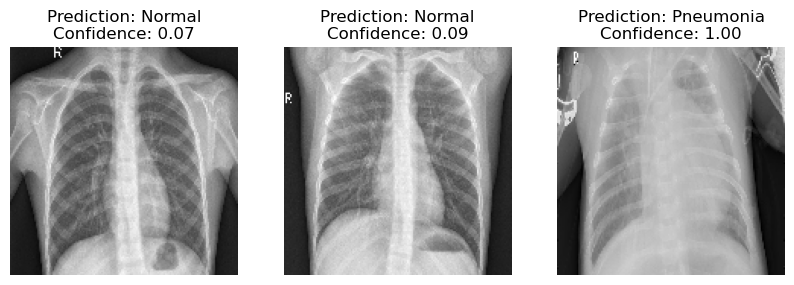

In [34]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Test resimlerinin bulunduğu dizin
test_images_dir = 'chest_xray/test'

# Test resimlerinin dosya adları
test_image_files = [
    'IM-0001-0001.jpeg',
    'IM-0003-0001.jpeg',
    'person1_virus_7.jpeg'
]

# Resimleri yükleyip tahmin yapma
def load_and_predict_image(image_path, model):
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

    prediction = model.predict(img_array)
    return img, prediction

plt.figure(figsize=(10, 10))

for i, img_file in enumerate(test_image_files):
    img_path = os.path.join(test_images_dir, img_file)
    img, prediction = load_and_predict_image(img_path, model)

    plt.subplot(1, len(test_image_files), i+1)
    plt.imshow(img)
    plt.title(f'Prediction: {"Pneumonia" if prediction[0][0] > 0.5 else "Normal"}\nConfidence: {prediction[0][0]:.2f}')
    plt.axis('off')

plt.show()
